# duie 数据预处理

In [3]:
import json
import numpy as np
import os
import re
import torch

from collections import Counter, defaultdict
from my_py_toolkit.file.file_toolkit import readjson, writejson, read_file
from my_py_toolkit.data_visulization.matplotlib import plot_coh, plot_coh_dict
from my_py_toolkit.torch.transformers_pkg import bert_tokenize
from my_py_toolkit.ml.data.text_preprocess import tokenize_chinese

c:\Users\dream\.conda\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\dream\.conda\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\dream\.conda\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\dream\.conda\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.

In [4]:
# 分析确定超参
max_len = 256 # 范围在 5~300， 256 包含绝大部分数据了, 实验的时候多试下这个参数, eg: 128, 300 等

In [5]:
# 参数
data_dir = '../resources/dataset/duie'
data_files = ['train_data.json', 'dev_data.json']
schemas_file = 'all_50_chemas'
bert_cfg = '../resources/bert_model/bert'


In [6]:
# 读取所有数据

def readdata(paths):
    datas = []
    for p in paths:
        for line in read_file(p, '\n'):
            if line:
                datas.append(json.loads(line))
    return datas

datas = readdata([os.path.join(data_dir, f) for f in data_files])
len(datas)



194609

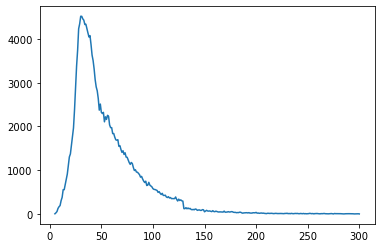

In [7]:
# 统计 text 的长度
len_counts = Counter([len(l['text']) for l in datas])
plot_coh_dict(len_counts)

In [13]:
sorted([(s, t) for s,t in len_counts.items()], key=lambda x:x[0])

[(5, 4),
 (6, 26),
 (7, 55),
 (8, 127),
 (9, 166),
 (10, 192),
 (11, 305),
 (12, 380),
 (13, 555),
 (14, 555),
 (15, 671),
 (16, 775),
 (17, 912),
 (18, 1116),
 (19, 1304),
 (20, 1373),
 (21, 1571),
 (22, 1765),
 (23, 1967),
 (24, 2380),
 (25, 2857),
 (26, 3381),
 (27, 3742),
 (28, 4235),
 (29, 4348),
 (30, 4521),
 (31, 4519),
 (32, 4462),
 (33, 4432),
 (34, 4332),
 (35, 4338),
 (36, 4235),
 (37, 4140),
 (38, 4047),
 (39, 4078),
 (40, 3874),
 (41, 3634),
 (42, 3509),
 (43, 3317),
 (44, 3072),
 (45, 2906),
 (46, 2817),
 (47, 2641),
 (48, 2374),
 (49, 2513),
 (50, 2324),
 (51, 2296),
 (52, 2323),
 (53, 2107),
 (54, 2221),
 (55, 2162),
 (56, 2256),
 (57, 2232),
 (58, 2036),
 (59, 1974),
 (60, 1974),
 (61, 1837),
 (62, 1839),
 (63, 1757),
 (64, 1696),
 (65, 1686),
 (66, 1698),
 (67, 1547),
 (68, 1560),
 (69, 1474),
 (70, 1408),
 (71, 1445),
 (72, 1361),
 (73, 1399),
 (74, 1301),
 (75, 1297),
 (76, 1235),
 (77, 1175),
 (78, 1133),
 (79, 1177),
 (80, 1154),
 (81, 1064),
 (82, 994),
 (83, 101

In [8]:
txt = '《其实我们很熟》是由陈奂仁作词、作曲，余文乐演唱的一首歌曲，收录于专辑《不是明星n.a.s.Ⅱ》中，发行于2011年04月13日'
reg = '不是明星N.A.S.ⅱ'
match = re.search(re.escape(reg), txt, re.I)
match, match.span()

(<_sre.SRE_Match object; span=(36, 47), match='不是明星n.a.s.Ⅱ'>, (36, 47))

Data label error: obj:胡抗美, sub:康里巎巎《杂诗》 txt:这本《康里巎巎杂诗(全彩色高清珍藏本)》(作者胡抗美)是其中一册
Data label error: obj:裸婚——80后的新结婚时代, sub:裸婚时代 txt:吴磊《沙海》《斗破苍穹》吴磊的《沙海》，除了吴磊 ，还有秦昊 、杨蓉、张萌、张铭恩、朱杰 等人主演的现代探险题材电视剧，该剧改编自南派三叔同名小说，普通高中生黎簇被卷入一个以世界现状为目的庞大计划中，然后认识了这一切的幕后布局者、以旅行摄影作家关根身份登场的吴邪的故事
Data label error: obj:王立群, sub:王立群读《史记》 txt:2008年1月24日上午9点半，央视“百家讲坛”栏目主讲人王立群将携《王立群读史记之 项羽 》在北京长城饭店召开新书首发会，欢迎有兴趣的读者到场参加
Data label error: obj:白发魔女传, sub:白发魔女传 txt:2010年9月，在《创:战纪》上映前，迪士尼曾聘请《无间行者》、《天国王朝》编剧威廉·莫纳汉为电影版改编剧本
Data label error: obj:15万平方米, sub:桂林国际会展中心 txt:概述桂林国际会展中心位于素有百里画廊之称的漓江之滨，是桂林市标志性建筑，占地面积 15 万平方米，建筑总面积 5
Data label error: obj:人民文学出版社, sub:《千字文》全解 txt:《千字文全解》是2009年人民文学出版社出版的图书，作者是李小龙
Data label error: obj:马银琴, sub:周秦时代《诗》的传播史 txt:周秦时代诗的传播史是社会科学文献出版社出版的，马银琴编写的图书
Data label error: obj:社会科学文献出版社, sub:周秦时代《诗》的传播史 txt:周秦时代诗的传播史是社会科学文献出版社出版的，马银琴编写的图书
Data label error: obj:山楂树之恋, sub:山楂树之恋 txt:《裸婚时代》改编自80后网络作家唐欣恬的小说《裸婚——80后的新结婚时代》，由北京光彩世纪文化艺术有限公司出品，导演滕华涛执导，文章首次担当编剧，文章、姚笛、张凯丽、丁嘉丽、韩童生、万茜等主演


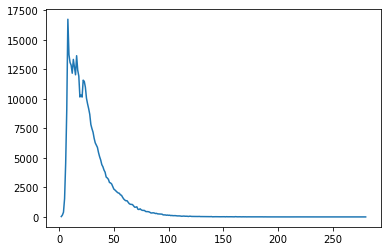

In [9]:
# 统计包含两个实体的最短 txt 的长度
minlen_txt = []
label_err_data = []
for data in datas:
    txt = data['text'].lower()
    for spo in data['spo_list']:
        obj = spo['object']
        sub = spo['subject']
        obj_match = re.search(re.escape(obj), txt, re.I)
        sub_match = re.search(re.escape(sub), txt, re.I)
        if not obj_match or not sub_match:
            print(f'Data label error: obj:{obj}, sub:{sub} txt:{txt}')
            label_err_data.append((obj, sub, txt))
            continue
        obj_s, obj_e = obj_match.span()
        sub_s, sub_e = sub_match.span()
        minlen_txt.append( max(obj_e, sub_e) - min(obj_s, sub_s))
minlen_txt = Counter(minlen_txt)
plot_coh_dict(minlen_txt)

In [61]:
# 看下 label 错误的两条数据
txt = ['吴磊《沙海》《斗破苍穹》吴磊的《沙海》，除了吴磊 ，还有秦昊 、杨蓉、张萌、张铭恩、朱杰 等人主演的现代探险题材电视剧，该剧改编自南派三叔同名小说，普通高中生黎簇被卷入一个以世界现状为目的庞大计划中，然后认识了这一切的幕后布局者、以旅行摄影作家关根身份登场的吴邪的故事', '《裸婚时代》改编自80后网络作家唐欣恬的小说《裸婚——80后的新结婚时代》，由北京光彩世纪文化艺术有限公司出品，导演滕华涛执导，文章首次担当编剧，文章、姚笛、张凯丽、丁嘉丽、韩童生、万茜等主演']
for data in datas:
    for t in txt:
        if t in data['text']:
            print(data)
            break
    


{'postag': [{'word': '吴磊', 'pos': 'nr'}, {'word': '《', 'pos': 'w'}, {'word': '沙海', 'pos': 'nw'}, {'word': '》', 'pos': 'w'}, {'word': '《', 'pos': 'w'}, {'word': '斗破苍穹', 'pos': 'nw'}, {'word': '》', 'pos': 'w'}, {'word': '吴磊', 'pos': 'nr'}, {'word': '的', 'pos': 'u'}, {'word': '《', 'pos': 'w'}, {'word': '沙海', 'pos': 'nw'}, {'word': '》', 'pos': 'w'}, {'word': '，', 'pos': 'w'}, {'word': '除了', 'pos': 'p'}, {'word': '吴磊', 'pos': 'nr'}, {'word': ' ', 'pos': 'w'}, {'word': '，', 'pos': 'w'}, {'word': '还有', 'pos': 'v'}, {'word': '秦昊', 'pos': 'nr'}, {'word': ' ', 'pos': 'w'}, {'word': '、', 'pos': 'w'}, {'word': '杨蓉', 'pos': 'nr'}, {'word': '、', 'pos': 'w'}, {'word': '张萌', 'pos': 'nr'}, {'word': '、', 'pos': 'w'}, {'word': '张铭恩', 'pos': 'nr'}, {'word': '、', 'pos': 'w'}, {'word': '朱杰', 'pos': 'nr'}, {'word': ' ', 'pos': 'w'}, {'word': '等人', 'pos': 'n'}, {'word': '主演', 'pos': 'v'}, {'word': '的', 'pos': 'u'}, {'word': '现代', 'pos': 't'}, {'word': '探险', 'pos': 'vn'}, {'word': '题材', 'pos': 'n'}, {'word': '

In [35]:
sorted([(k,v) for k,v in minlen_txt.items()], key=lambda x: x[0])

[(2, 32),
 (3, 155),
 (4, 399),
 (5, 1550),
 (6, 4542),
 (7, 9093),
 (8, 16753),
 (9, 13744),
 (10, 13092),
 (11, 12860),
 (12, 12178),
 (13, 13350),
 (14, 12720),
 (15, 12046),
 (16, 13663),
 (17, 12435),
 (18, 11931),
 (19, 10163),
 (20, 10332),
 (21, 10155),
 (22, 11590),
 (23, 11483),
 (24, 10993),
 (25, 10057),
 (26, 9580),
 (27, 9173),
 (28, 8695),
 (29, 7834),
 (30, 7478),
 (31, 7179),
 (32, 6667),
 (33, 6280),
 (34, 6081),
 (35, 5894),
 (36, 5452),
 (37, 5103),
 (38, 4823),
 (39, 4431),
 (40, 4255),
 (41, 3974),
 (42, 3791),
 (43, 3380),
 (44, 3302),
 (45, 3190),
 (46, 2920),
 (47, 2879),
 (48, 2790),
 (49, 2571),
 (50, 2360),
 (51, 2283),
 (52, 2191),
 (53, 2100),
 (54, 2031),
 (55, 2004),
 (56, 1874),
 (57, 1831),
 (58, 1666),
 (59, 1523),
 (60, 1433),
 (61, 1369),
 (62, 1378),
 (63, 1254),
 (64, 1129),
 (65, 1073),
 (66, 1062),
 (67, 1050),
 (68, 942),
 (69, 827),
 (70, 826),
 (71, 857),
 (72, 647),
 (73, 630),
 (74, 688),
 (75, 601),
 (76, 558),
 (77, 550),
 (78, 547),
 (79

In [18]:
# object, subject 在 text 找不到的数量
len(label_err_data)

916

In [33]:
# 处理完 object, subject 与 text 大小写对不上问题后
len(label_err_data)

9

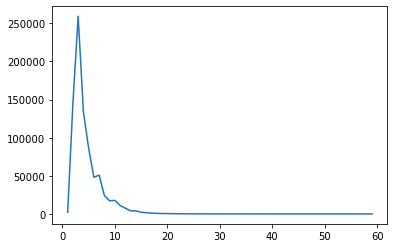

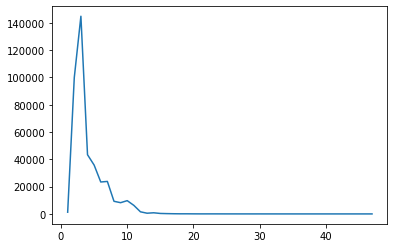

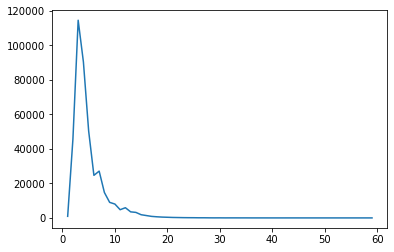

(None, None, None)

In [10]:
# 统计 object, subject 长度
len_obj = []
len_sub = []
len_objsub = []
for data in datas:
    for spo in data['spo_list']:
        len_obj.append(len(spo['object']))
        len_sub.append(len(spo['subject']))
len_objsub = len_obj + len_sub

len_obj = Counter(len_obj)
len_sub = Counter(len_sub)
len_objsub = Counter(len_objsub)
plot_coh_dict(len_objsub), plot_coh_dict(len_obj), plot_coh_dict(len_sub)

c:\Users\dream\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 19976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\dream\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 22827 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\dream\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20154 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\dream\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 29289 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\dream\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 19978 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\dream\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:214: 

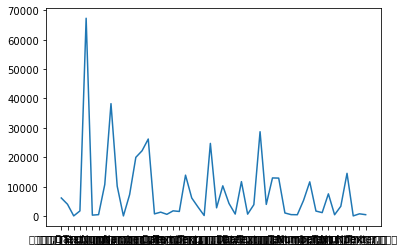

In [11]:
# 统计关系的数量
rel_count = defaultdict(int)
for data in datas:
    for spo in data['spo_list']:
        rel = ','.join([spo[k] for k in ['predicate', 'object_type', 'subject_type']])
        rel_count[rel] += 1

plot_coh_dict(rel_count)

In [48]:
sorted([(k, v) for k,v in rel_count.items()], key=lambda x: x[1], reverse=True)

[('主演,人物,影视作品', 67275),
 ('作者,人物,图书作品', 38217),
 ('歌手,人物,歌曲', 28667),
 ('出生日期,Date,人物', 26182),
 ('导演,人物,影视作品', 24694),
 ('出生地,地点,人物', 22182),
 ('出版社,出版社,书籍', 19955),
 ('连载网站,网站,网络小说', 14509),
 ('国籍,国家,人物', 13890),
 ('毕业院校,学校,人物', 12943),
 ('民族,Text,人物', 12888),
 ('所属专辑,音乐专辑,歌曲', 11685),
 ('目,目,生物', 11613),
 ('作曲,人物,歌曲', 10720),
 ('成立日期,Date,企业', 10261),
 ('作词,人物,歌曲', 10154),
 ('编剧,人物,影视作品', 7531),
 ('出品公司,企业,影视作品', 7266),
 ('妻子,人物,人物', 6124),
 ('丈夫,人物,人物', 6124),
 ('父亲,人物,人物', 5304),
 ('成立日期,Date,机构', 4253),
 ('上映时间,Date,影视作品', 3985),
 ('母亲,人物,人物', 3937),
 ('朝代,Text,历史人物', 3848),
 ('身高,Number,人物', 3298),
 ('字,Text,历史人物', 3072),
 ('总部地点,地点,企业', 2775),
 ('号,Text,历史人物', 1748),
 ('主持人,人物,电视综艺', 1719),
 ('祖籍,地点,人物', 1672),
 ('嘉宾,人物,电视综艺', 1539),
 ('制片人,人物,影视作品', 1304),
 ('简称,Text,机构', 1144),
 ('气候,气候,行政区', 1023),
 ('面积,Number,行政区', 736),
 ('创始人,人物,企业', 714),
 ('所在城市,城市,景点', 652),
 ('改编自,作品,影视作品', 624),
 ('占地面积,Number,机构', 563),
 ('注册资本,Number,企业', 460),
 ('人口数量,Number,行政区', 452),
 ('首都,城市,

In [50]:
[k for k in rel_count]

['主演,人物,影视作品',
 '目,目,生物',
 '身高,Number,人物',
 '出生日期,Date,人物',
 '国籍,国家,人物',
 '连载网站,网站,网络小说',
 '作者,人物,图书作品',
 '歌手,人物,歌曲',
 '海拔,Number,地点',
 '出生地,地点,人物',
 '导演,人物,影视作品',
 '气候,气候,行政区',
 '朝代,Text,历史人物',
 '妻子,人物,人物',
 '丈夫,人物,人物',
 '民族,Text,人物',
 '毕业院校,学校,人物',
 '编剧,人物,影视作品',
 '出品公司,企业,影视作品',
 '父亲,人物,人物',
 '出版社,出版社,书籍',
 '作词,人物,歌曲',
 '作曲,人物,歌曲',
 '母亲,人物,人物',
 '成立日期,Date,企业',
 '字,Text,历史人物',
 '号,Text,历史人物',
 '所属专辑,音乐专辑,歌曲',
 '所在城市,城市,景点',
 '总部地点,地点,企业',
 '主持人,人物,电视综艺',
 '上映时间,Date,影视作品',
 '首都,城市,国家',
 '成立日期,Date,机构',
 '创始人,人物,企业',
 '祖籍,地点,人物',
 '改编自,作品,影视作品',
 '制片人,人物,影视作品',
 '注册资本,Number,企业',
 '人口数量,Number,行政区',
 '面积,Number,行政区',
 '主角,人物,网络小说',
 '占地面积,Number,机构',
 '嘉宾,人物,电视综艺',
 '简称,Text,机构',
 '董事长,人物,企业',
 '官方语言,语言,国家',
 '邮政编码,Text,行政区',
 '专业代码,Text,学科专业',
 '修业年限,Number,学科专业']

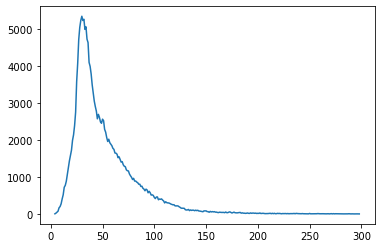

In [12]:
# 统计 token 长度
tokenizer = bert_tokenize(bert_cfg)
len_tokens = []
for data in datas:
    len_tokens.append(len(tokenize_chinese(tokenizer, data['text'])))
len_tokens = Counter(len_tokens)
plot_coh_dict(len_tokens)

In [59]:
sorted([(k, v) for k,v in len_tokens.items()], key=lambda x:x[0])

[(4, 4),
 (5, 22),
 (6, 49),
 (7, 74),
 (8, 166),
 (9, 201),
 (10, 274),
 (11, 407),
 (12, 519),
 (13, 722),
 (14, 773),
 (15, 886),
 (16, 1071),
 (17, 1258),
 (18, 1437),
 (19, 1580),
 (20, 1726),
 (21, 1990),
 (22, 2141),
 (23, 2391),
 (24, 2755),
 (25, 3580),
 (26, 4075),
 (27, 4717),
 (28, 5048),
 (29, 5238),
 (30, 5349),
 (31, 5234),
 (32, 5267),
 (33, 4994),
 (34, 5063),
 (35, 4729),
 (36, 4636),
 (37, 4099),
 (38, 3994),
 (39, 3787),
 (40, 3494),
 (41, 3277),
 (42, 3055),
 (43, 2908),
 (44, 2785),
 (45, 2574),
 (46, 2694),
 (47, 2613),
 (48, 2491),
 (49, 2453),
 (50, 2564),
 (51, 2524),
 (52, 2289),
 (53, 2214),
 (54, 2071),
 (55, 1961),
 (56, 2022),
 (57, 1928),
 (58, 1888),
 (59, 1847),
 (60, 1776),
 (61, 1748),
 (62, 1649),
 (63, 1644),
 (64, 1616),
 (65, 1521),
 (66, 1545),
 (67, 1470),
 (68, 1402),
 (69, 1415),
 (70, 1331),
 (71, 1291),
 (72, 1279),
 (73, 1194),
 (74, 1169),
 (75, 1164),
 (76, 1081),
 (77, 1033),
 (78, 992),
 (79, 932),
 (80, 964),
 (81, 890),
 (82, 891),
 

In [16]:
# duie 数据预处理

def check_scope(scope, idx_transf, txt):
    s, e = scope
    while e < len(txt) - 1 and not txt[e]:
        e += 1
    s_ori, e_ori = idx_transf.to_ori_scope(*idx_transf.to_new_scope(s, e))
    while e_ori >0 and txt[e_ori] == ' ':
        e_ori -= 1

    return  s == s_ori and e == e_ori

def handle_data(datas, bert_cfg):
    all_tokens = []
    all_spo = []
    all_text = []
    all_label = []
    all_new2ori_idx = []
    all_ori2new_idx = []

    tokenizer = bert_tokenize(bert_cfg)
    for data in datas:
        txt = data['text']
        tokens, idx_transf = tokenize_chinese(tokenizer, txt, True)
        spo_list = []
        keys = ['object', 'subject', 'predicate', 'object_type', 'subject_type']
        for spo in data['spo_list']:
            obj, sub, pre, ot, st = [spo[k] for k in keys]
            obj_match, sub_match = [re.search(re.escape(reg), txt, re.I) for reg in [obj, sub]]
            if not obj_match or not sub_match:
                print(f'Label error, obj: {obj}, sub: {sub}, txt: {txt}')
                continue
            obj_s, obj_e = obj_match.span()
            sub_s, sub_e = sub_match.span()
            if not all([check_scope(scope, idx_transf, txt) for scope in [[obj_s, obj_e], [sub_s, sub_e]]]):
                print(f'Tokens not match, obj:{obj}, sub:{sub}, txt:{txt}')
                continue
            spo_list.append([obj_s, obj_e, ','.join([pre, ot, st]), sub_s, sub_e])
        all_tokens.append(tokens)
        all_spo.append(spo_list)
        all_text.append(txt)
        all_ori2new_idx.append(idx_transf.ori2new_idx)
        all_new2ori_idx.append(idx_transf.new2ori_idx)
        all_label.append(data['spo_list'])
    return (all_tokens, all_spo, all_text, all_label, all_ori2new_idx, all_new2ori_idx)
        
            

datas_handled = handle_data(datas, bert_cfg)
    




Tokens not match, obj:法国, sub:伊万-佩恩, txt:个人信息姓名：伊万-佩恩 Erwan Peron (法国)  国籍：法国  性别：男  生日：1980
Tokens not match, obj:1930年4月, sub:刘才光, txt:刘才光  男，1930年4月生，福建福州人
Tokens not match, obj:福建福州, sub:刘才光, txt:刘才光  男，1930年4月生，福建福州人
Tokens not match, obj:纳豆, sub:电玩快打, txt:0后的第三波主持人：纳豆、夏宇童-(代班2周) 节目改名电玩快打 VER 2
Tokens not match, obj:夏宇童, sub:电玩快打, txt:0后的第三波主持人：纳豆、夏宇童-(代班2周) 节目改名电玩快打 VER 2
Tokens not match, obj:1981年1月4日, sub:阮辉煌, txt:基本资料球员:阮辉煌  生日:1981年1月4日  身高:173cm  球衣号码:3  国籍:越南  效力球队:义安蓝江  场上位置:后卫球队阵容前锋  D
Tokens not match, obj:越南, sub:阮辉煌, txt:基本资料球员:阮辉煌  生日:1981年1月4日  身高:173cm  球衣号码:3  国籍:越南  效力球队:义安蓝江  场上位置:后卫球队阵容前锋  D
Tokens not match, obj:173cm, sub:阮辉煌, txt:基本资料球员:阮辉煌  生日:1981年1月4日  身高:173cm  球衣号码:3  国籍:越南  效力球队:义安蓝江  场上位置:后卫球队阵容前锋  D
Tokens not match, obj:周杰伦, sub:青花瓷, txt:烟花易冷周杰伦 - 跨时代后来的《青花瓷》《烟花易冷》等等，至少，在我听过的华语流行歌曲中，优质的填词很多，可工整如此的，并不多见
Tokens not match, obj:周杰伦, sub:烟花易冷, txt:烟花易冷周杰伦 - 跨时代后来的《青花瓷》《烟花易冷》等等，至少，在我听过的华语流行歌曲中，优质的填词很多，可工整如此的，并不多见
Tokens not match, obj:1988年3月23日, sub:卡路尔,

KeyboardInterrupt: 

In [5]:
len(datas_handled)

NameError: name 'datas_handled' is not defined

In [24]:
# obj:176cm, sub:莫巴利, txt:姓名：莫巴利（Mobali） 国籍：伊朗 场上位置：中场 出生日期：1982-11-03 身高：176cm 体重：75kg 现效力俱乐部：福拉德队 曾效力俱乐部：福拉德队 特点：传球意识出色，攻防俱佳
txt = '姓名：莫巴利（Mobali） 国籍：伊朗 场上位置：中场 出生日期：1982-11-03 身高：176cm 体重：75kg 现效力俱乐部：福拉德队 曾效力俱乐部：福拉德队 特点：传球意识出色，攻防俱佳'
tokens, idx_tranf = tokenize_chinese(tokenizer, txt, True)
tokens

['姓',
 '名',
 '：',
 '莫',
 '巴',
 '利',
 '（',
 'moba',
 '##li',
 '）',
 '国',
 '籍',
 '：',
 '伊',
 '朗',
 '场',
 '上',
 '位',
 '置',
 '：',
 '中',
 '场',
 '出',
 '生',
 '日',
 '期',
 '：',
 '1982',
 '-',
 '11',
 '-',
 '03',
 '身',
 '高',
 '：',
 '176',
 '##cm',
 '体',
 '重',
 '：',
 '75',
 '##kg',
 '现',
 '效',
 '力',
 '俱',
 '乐',
 '部',
 '：',
 '福',
 '拉',
 '德',
 '队',
 '曾',
 '效',
 '力',
 '俱',
 '乐',
 '部',
 '：',
 '福',
 '拉',
 '德',
 '队',
 '特',
 '点',
 '：',
 '传',
 '球',
 '意',
 '识',
 '出',
 '色',
 '，',
 '攻',
 '防',
 '俱',
 '佳']

In [18]:
txt = '刘才光  男，1930年4月生，福建福州人'
tokens, idx_tranf = tokenize_chinese(tokenizer, txt, True)


In [19]:
idx_tranf.to_new_scope(0, 4)

[0, 2]

In [21]:
idx_tranf.to_ori_scope(0,3)

[0, 5]

In [12]:
idx_tranf.to_new_scope(21, 25)

[21, 25]

In [13]:
idx_tranf.to_ori_scope(21, 25)

[21, 25]

In [17]:
check_scope((21, 25), idx_tranf)

False

In [32]:
scope = [48, 53]
idx_tranf.to_ori_scope(*idx_tranf.to_new_scope(*scope))

[48, 51]

In [33]:
idx_tranf.to_new_scope(*scope)

[35, 36]

In [35]:
idx_tranf.ori2new_idx[48:]

[35,
 35,
 35,
 36,
 36,
 36,
 37,
 38,
 39,
 40,
 40,
 41,
 41,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77]

In [31]:
tokens[35:]

['176',
 '##cm',
 '体',
 '重',
 '：',
 '75',
 '##kg',
 '现',
 '效',
 '力',
 '俱',
 '乐',
 '部',
 '：',
 '福',
 '拉',
 '德',
 '队',
 '曾',
 '效',
 '力',
 '俱',
 '乐',
 '部',
 '：',
 '福',
 '拉',
 '德',
 '队',
 '特',
 '点',
 '：',
 '传',
 '球',
 '意',
 '识',
 '出',
 '色',
 '，',
 '攻',
 '防',
 '俱',
 '佳']

In [14]:
idx_tranf.ori2new_idx

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42]

In [44]:
a = defaultdict(int)
a['a'] += 1
a

defaultdict(int, {'a': 1})

In [46]:
a = defaultdict()
a['a'] += 1
a

KeyError: 'a'

In [21]:
# 将 txt 转小写后错误数据
len(label_err_data)

12775

In [23]:
# object, subject 不在 txt时，将 text 转小写后
len(label_err_data)

12775

In [14]:
datas[0]

{'postag': [{'word': '如何', 'pos': 'r'},
  {'word': '演', 'pos': 'v'},
  {'word': '好', 'pos': 'a'},
  {'word': '自己', 'pos': 'r'},
  {'word': '的', 'pos': 'u'},
  {'word': '角色', 'pos': 'n'},
  {'word': '，', 'pos': 'w'},
  {'word': '请', 'pos': 'v'},
  {'word': '读', 'pos': 'v'},
  {'word': '《', 'pos': 'w'},
  {'word': '演员自我修养', 'pos': 'nw'},
  {'word': '》', 'pos': 'w'},
  {'word': '《', 'pos': 'w'},
  {'word': '喜剧之王', 'pos': 'nw'},
  {'word': '》', 'pos': 'w'},
  {'word': '周星驰', 'pos': 'nr'},
  {'word': '崛起', 'pos': 'v'},
  {'word': '于', 'pos': 'p'},
  {'word': '穷困潦倒', 'pos': 'a'},
  {'word': '之中', 'pos': 'f'},
  {'word': '的', 'pos': 'u'},
  {'word': '独门', 'pos': 'n'},
  {'word': '秘笈', 'pos': 'n'}],
 'text': '如何演好自己的角色，请读《演员自我修养》《喜剧之王》周星驰崛起于穷困潦倒之中的独门秘笈',
 'spo_list': [{'predicate': '主演',
   'object_type': '人物',
   'subject_type': '影视作品',
   'object': '周星驰',
   'subject': '喜剧之王'}]}